In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2024-03-25 17:41:42.676506: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 17:41:42.776329: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 17:41:43.071886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 17:41:44.154092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


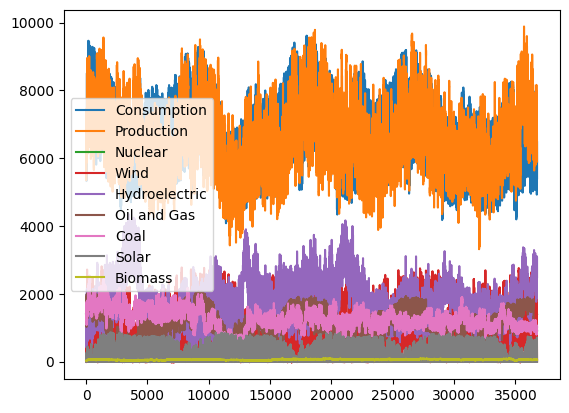

In [4]:
# https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production

df = pd.read_csv('data/electricityConsumptionAndProductioction.csv')

df.plot()
df.head()

In [53]:
df.describe()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
count,36772.000000,36772.000000,36772.000000,36772.000000,36772.000000,36772.000000,36772.000000,36772.000000,36772.000000
mean,6707.924889,6543.770478,1293.468590,785.700723,1801.603149,1181.630017,1270.038236,151.524094,58.730828
std,1034.961146,1005.486125,237.348752,681.508967,678.981785,422.487653,306.550193,222.768784,13.363835
min,4081.000000,3315.000000,612.000000,-26.000000,175.000000,213.000000,279.000000,0.000000,18.000000
25%,5895.750000,5833.000000,1349.000000,226.000000,1310.000000,881.000000,1080.000000,0.000000,49.000000
50%,6686.000000,6492.000000,1386.000000,577.000000,1708.000000,1216.000000,1254.000000,2.000000,61.000000
75%,7434.000000,7210.000000,1409.000000,1195.250000,2184.000000,1502.000000,1467.000000,268.000000,68.000000
max,9615.000000,9886.000000,1457.000000,2811.000000,4359.000000,2141.000000,2537.000000,869.000000,89.000000


Т.К. Производство суммирует показатели по видам производств, то для начала отбросим их, оставив природные источники. Для более быстрых расчетов возьмем первые 1000 значений.

In [7]:
df_main = df.copy()

df_main = df_main.head(1000)[['DateTime', 'Consumption', 'Production', 'Wind', 'Solar']]
df_main.head()

,DateTime,Consumption,Production,Wind,Solar
0,2019-01-01 00:00:00,6352,6527,79,0
1,2019-01-01 01:00:00,6116,5701,96,0
2,2019-01-01 02:00:00,5873,5676,142,0
3,2019-01-01 03:00:00,5682,5603,191,0
4,2019-01-01 04:00:00,5557,5454,159,0


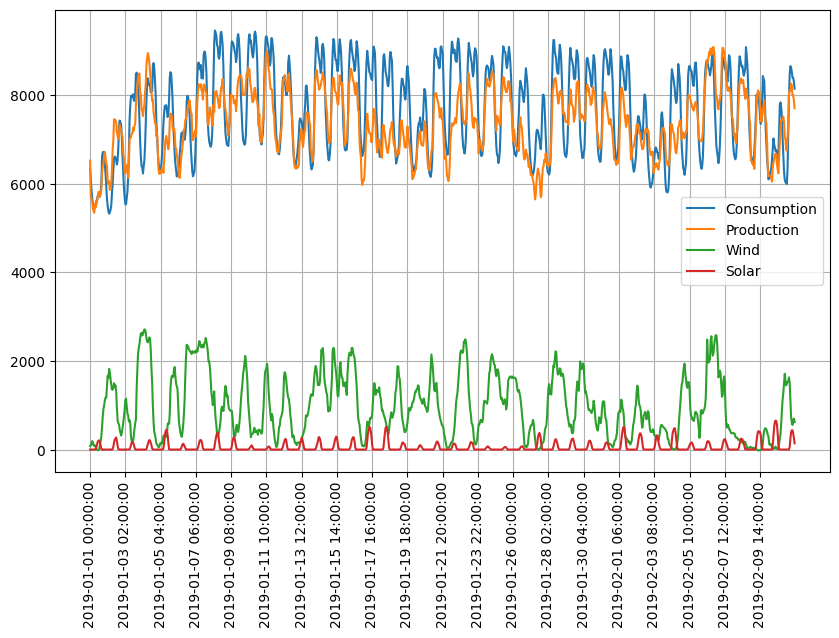

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(df_main['DateTime'], df_main['Consumption'], label='Consumption')
plt.plot(df_main['DateTime'], df_main['Production'], label='Production')
plt.plot(df_main['DateTime'], df_main['Wind'], label='Wind')
plt.plot(df_main['DateTime'], df_main['Solar'], label='Solar')

plt.xticks(df_main['DateTime'][::50], rotation='vertical')

plt.legend()
plt.grid(True)

plt.show()

In [1]:
#Функция для теста Дики-Фуллера

def di_fu_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    if result[1] < 0.05:
        print("Ряд является стационарным")
    else:
        print("Ряд не является стационарным")

VAR

In [ ]:
#Скопируем датасет для VAR модели
df_var = df_main.copy()
df_var = df_var.drop(columns='DateTime')

In [36]:
df_var.head()

,Consumption,Production,Wind,Solar
0,6352,6527,79,0
1,6116,5701,96,0
2,5873,5676,142,0
3,5682,5603,191,0
4,5557,5454,159,0


In [39]:
for name, column in df_var.items():
    print(name)
    di_fu_test(column)
    print()

Consumption
ADF Statistic: -3.417139
p-value: 0.010388
Ряд является стационарным

Production
ADF Statistic: -3.765934
p-value: 0.003276
Ряд является стационарным

Wind
ADF Statistic: -7.370361
p-value: 0.000000
Ряд является стационарным

Solar
ADF Statistic: -3.083654
p-value: 0.027787
Ряд является стационарным



In [40]:
train, test = train_test_split(df_var, test_size=0.2, shuffle=False)

In [42]:
model = VAR(train)
x = model.select_order(maxlags=100)
model_fitted = model.fit(x.aic)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 25, Mar, 2024
Time:                     18:01:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    36.9253
Nobs:                     774.000    HQIC:                   35.3724
Log likelihood:          -17286.3    FPE:                8.77377e+14
AIC:                      34.4012    Det(Omega_mle):     5.27466e+14
--------------------------------------------------------------------
Results for equation Consumption
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 309.955597        72.870940            4.253           0.000
L1.Consumption          1.394288         0.045752           30.475           0.000
L1.Production          -0.080048         0.035

In [45]:
forecast_input = train.values[-x.aic:]

In [58]:
#Предсказание
nobs = len(test) # количество точек для предсказания
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_var.index[-nobs:], columns=df_var.columns)

In [60]:
df_forecast.head()

,Consumption,Production,Wind,Solar
800,6716.599037,6352.303771,383.640274,29.253588
801,7008.214732,6467.801997,312.213275,100.683372
802,7078.966174,6546.212312,279.099422,173.334606
803,7075.701866,6612.455984,265.799881,225.519343
804,7108.061288,6701.682090,320.672619,254.167301


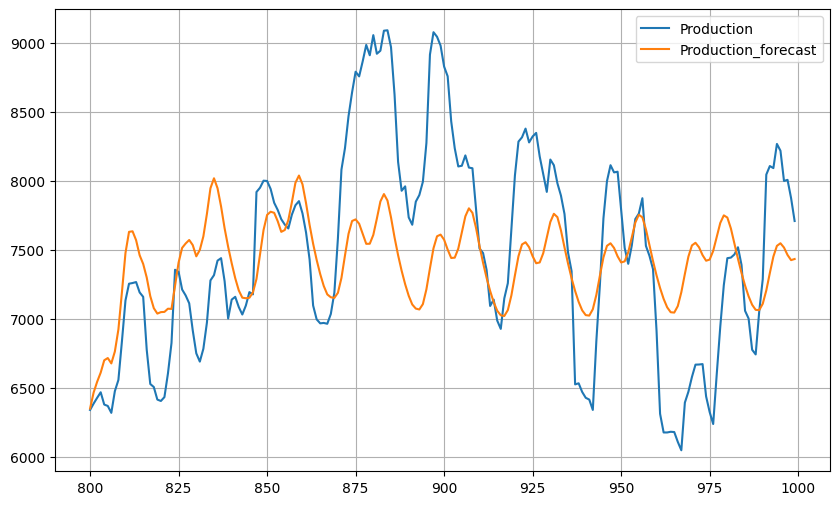

In [63]:
plt.figure(figsize=(10, 6))

plt.plot(test['Production'], label='Production')
plt.plot(df_forecast['Production'], label='Production_forecast')

#plt.xticks(df_main['DateTime'][::50], rotation='vertical')

plt.legend()
plt.grid(True)

plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

var_true = test['Production'].values
var_pred = df_forecast['Production'].values

print('R2:', r2_score(var_true, var_pred))
print('MAE:', mean_absolute_error(var_true, var_pred))
print('RMSE:', np.sqrt(mean_squared_error(var_true, var_pred)))

R2: 0.28347295853068233
MAE: 518.2663295256483
RMSE: 643.735315584969


VAR модель с задачей справилась, но не идеально.

LSTM

In [82]:
#Скопируем датасет для LSTM модели
df_lstm = df_main.copy()
df_lstm = df_lstm.drop(columns='DateTime')

train, test = train_test_split(df_lstm, test_size=0.25, shuffle=False)
print(train.shape)
print(test.shape)

(750, 4)
(250, 4)


In [76]:
df_lstm.head()

,Consumption,Production,Wind,Solar
0,6352,6527,79,0
1,6116,5701,96,0
2,5873,5676,142,0
3,5682,5603,191,0
4,5557,5454,159,0


In [101]:
#Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
production_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df_lstm)
scaled_production = production_scaler.fit_transform(df_lstm[['Production']])

train_length = int(len(scaled_data) * 0.8)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [102]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [103]:
#Преобразование данных для LSTM

look_back = 1
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

In [106]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [107]:
#Создание модели

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [108]:
#Обучение

model.fit(X_train, Y_train, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
798/798 - 2s - 3ms/step - loss: 0.0255
Epoch 2/30
798/798 - 1s - 2ms/step - loss: 0.0072
Epoch 3/30
798/798 - 1s - 2ms/step - loss: 0.0066
Epoch 4/30
798/798 - 1s - 2ms/step - loss: 0.0063
Epoch 5/30
798/798 - 3s - 3ms/step - loss: 0.0062
Epoch 6/30
798/798 - 1s - 2ms/step - loss: 0.0061
Epoch 7/30
798/798 - 1s - 2ms/step - loss: 0.0062
Epoch 8/30
798/798 - 1s - 2ms/step - loss: 0.0063
Epoch 9/30
798/798 - 2s - 3ms/step - loss: 0.0061
Epoch 10/30
798/798 - 3s - 3ms/step - loss: 0.0060
Epoch 11/30
798/798 - 1s - 2ms/step - loss: 0.0061
Epoch 12/30
798/798 - 1s - 2ms/step - loss: 0.0060
Epoch 13/30
798/798 - 1s - 2ms/step - loss: 0.0061
Epoch 14/30
798/798 - 1s - 2ms/step - loss: 0.0061
Epoch 15/30
798/798 - 3s - 3ms/step - loss: 0.0062
Epoch 16/30
798/798 - 3s - 3ms/step - loss: 0.0059
Epoch 17/30
798/798 - 3s - 3ms/step - loss: 0.0061
Epoch 18/30
798/798 - 3s - 3ms/step - loss: 0.0059
Epoch 19/30
798/798 - 1s - 2ms/step - loss: 0.0060
Epoch 20/30
798/798 - 3s - 3ms/step - lo

In [109]:
#Предсказываем для учебного и тестового набора

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [110]:
#Преобразовываем данные обратно

train_predict = production_scaler.inverse_transform(train_predict)
Y_train = production_scaler.inverse_transform([Y_train])
test_predict = production_scaler.inverse_transform(test_predict)
Y_test = production_scaler.inverse_transform([Y_test])

In [115]:
lstm_predictions = pd.DataFrame(test_predict, index=df_lstm.index[-len(test_predict):], columns=['LSTM_prediction'])

In [122]:
df_lstm_predict = pd.concat([df_lstm['Production'], lstm_predictions], axis=1)

<Axes: >

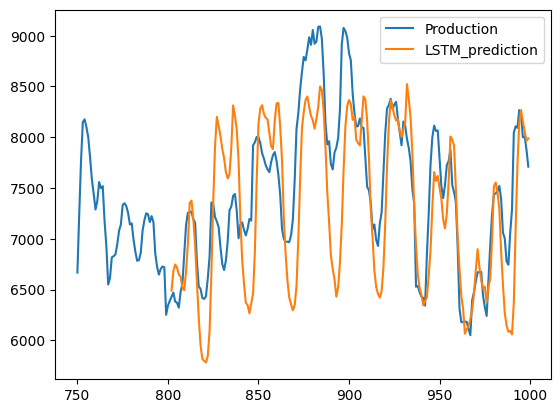

In [123]:
df_lstm_predict.tail(250).plot()

In [124]:
lstm_true = df_lstm_predict['Production'].iloc[-len(test_predict):].values
lstm_pred = df_lstm_predict['LSTM_prediction'].dropna().values

print('\nLSTM Metrics:')
print('R2:', r2_score(lstm_true, lstm_pred))
print('MAE:', mean_absolute_error(lstm_true, lstm_pred))
print('RMSE:', np.sqrt(mean_squared_error(lstm_true, lstm_pred)))


LSTM Metrics:
R2: 0.34858907849260556
MAE: 475.4664047703599
RMSE: 610.1729044252721


Эта модель справилась чуть лучше, чем VAR. Предположительно проблема в исходном наборе данных, который предоставляет слишком мало данных для предсказания.